<a href="https://colab.research.google.com/github/Rin-niee/MPSI/blob/main/lab5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas umap-learn transformers datasets scikit-learn torch evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import umap
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Пользователь\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Пользователь\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

1. Загрузка данных(был взят какой-то готовый датасетик из уже встроенных в библиотеку, 20000 новостей/статей, с фильтрацией по категориям). Датасет на английском языке, т.к данные могут быть точнее(?)

In [ ]:
categories = None #здесь нужно выбирать категории конкретные, я решила взять всю совокупность из 20 категорий
newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))
texts = newsgroups.data
labels = newsgroups.target
label_names = newsgroups.target_names

In [ ]:
import random
from collections import defaultdict

samples_per_class = 50
class_counts = defaultdict(int)

texts_subset = []
labels_subset = []

combined = list(zip(texts, labels))
random.shuffle(combined)  # перемешаем, чтобы классы шли не группами

for text, label in combined:
    if class_counts[label] < samples_per_class:
        texts_subset.append(text)
        labels_subset.append(label)
        class_counts[label] += 1
    if all(count >= samples_per_class for count in class_counts.values()):
        break

texts = texts_subset
labels = labels_subset

2. Предобработка текста(лемматизируем и убираем все ненужные стоп-слова)

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # убрать пунктуацию
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

In [ ]:
clean_texts = [preprocess(text) for text in texts]

In [ ]:
print(clean_texts[:10])

['sure bashers pen fan pretty confused lack kind post recent pen massacre devil actually bit puzzled bit relieved however going put end nonpittsburghers relief bit praise pen man killing devil worse thought jagr showed much better regular season stats also lot fun watch playoff bowman let jagr lot fun next couple game since pen going beat pulp jersey anyway disappointed see islander lose final regular season game pen rule', 'brother market highperformance video card support vesa local bus ram anyone suggestionsideas diamond stealth pro local bus orchid farenheit ati graphic ultra pro highperformance vlb card please post email thank matt', 'finally said dream mediterranean new area greater year like holocaust number ist july usa sweden april still cold changed calendar nothing mentioned true let say true shall azeri woman child going pay price raped killed tortured armenian hearded something called geneva convention facist ohhh forgot armenian fight nobody forgot killing rapings torture

3. Анализируем данные(распределение статей по категориям)

Количество документов: 18846
Количество категорий: 20


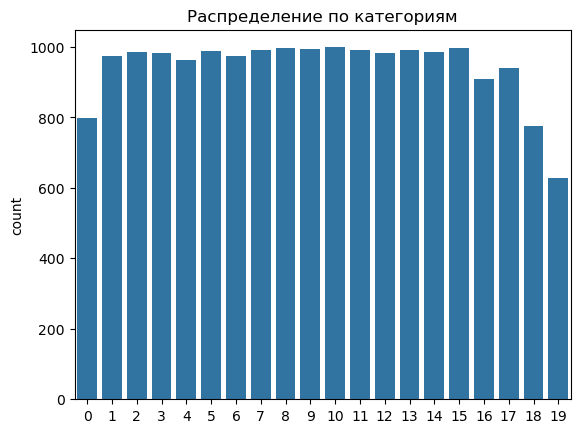

In [ ]:
print(f"Количество документов: {len(clean_texts)}")
print(f"Количество категорий: {len(label_names)}")
sns.countplot(x=labels) #категории взяты цифрами, потому что без них совсем уродливо
plt.title("Распределение по категориям")
plt.show()

4. Векторизируем с использованием специальной библиотеки

In [ ]:
vectorizer = TfidfVectorizer(max_features=20000) #увеличила количество на всякий случай, чтобы было поточнее
X = vectorizer.fit_transform(clean_texts)

5. Кластеризация

In [ ]:
kmeans = KMeans(n_clusters=len(label_names), random_state=42)
clusters = kmeans.fit_predict(X)

C:\anaconda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


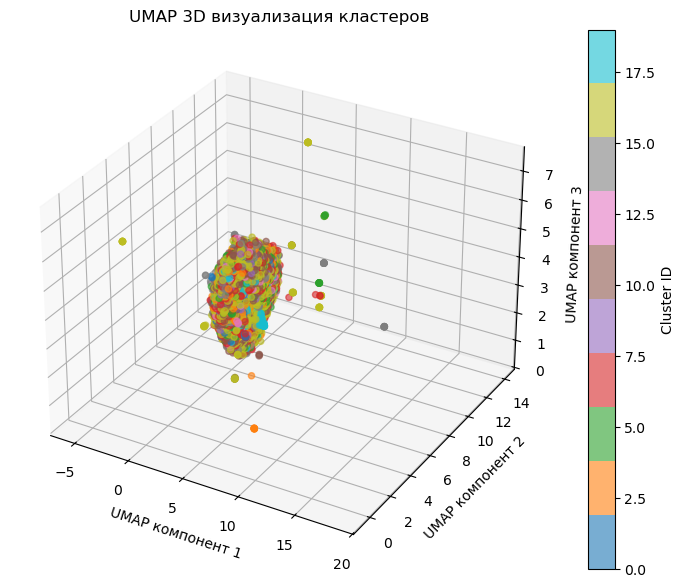

In [ ]:
# Применяем UMAP для уменьшения размерности до 3D
umap_model = umap.UMAP(n_components=3, random_state=42)
X_umap_3d = umap_model.fit_transform(X.toarray())

# Визуализируем результаты кластеризации в 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], X_umap_3d[:, 2],
                     c=clusters, cmap='tab10', alpha=0.6)

ax.set_title("UMAP 3D визуализация кластеров")
ax.set_xlabel("UMAP компонент 1")
ax.set_ylabel("UMAP компонент 2")
ax.set_zlabel("UMAP компонент 3")
plt.colorbar(scatter, ax=ax, label='Cluster ID')
plt.show()

6. Сравнение меток настоящих и после кластеризации

In [ ]:
ari = adjusted_rand_score(labels, clusters)
sil_score = silhouette_score(X, clusters)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Silhouette Score: {sil_score:.4f}")


KeyboardInterrupt



C:\Users\Пользователь\AppData\Local\Temp\ipykernel_11364\3088123518.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette='coolwarm')
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_11364\3088123518.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=clusters, palette='viridis')


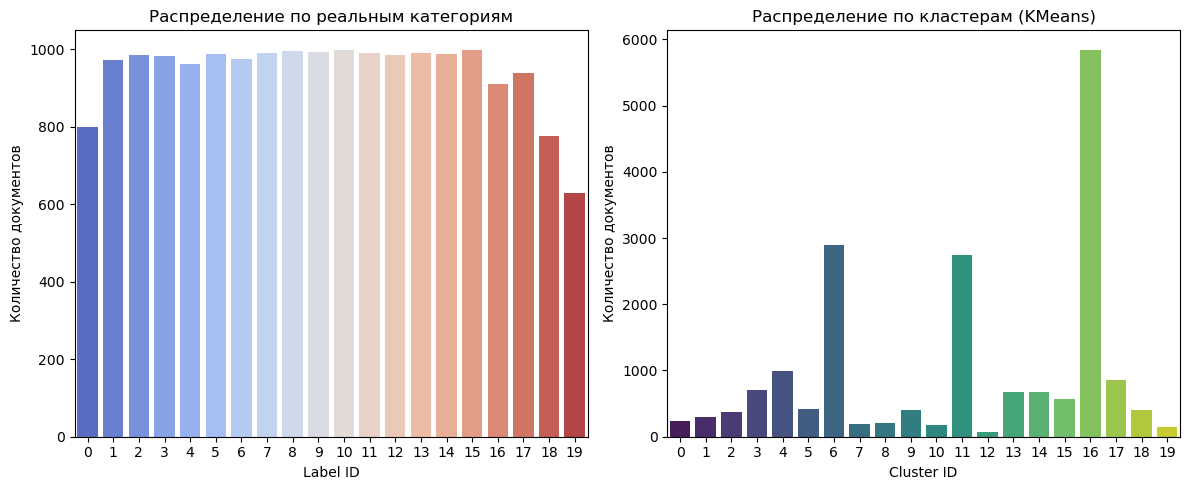

📊 Adjusted Rand Index (ARI): 0.0765 — насколько хорошо кластеры совпали с метками
📈 Silhouette Score: 0.0053 — насколько чёткие и отделимые получились кластеры


In [ ]:
# Визуализация распределения по реальным категориям
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=labels, palette='coolwarm')
plt.title("Распределение по реальным категориям")
plt.xlabel("Label ID")
plt.ylabel("Количество документов")

# Визуализация распределения по кластерам
plt.subplot(1, 2, 2)
sns.countplot(x=clusters, palette='viridis')
plt.title("Распределение по кластерам (KMeans)")
plt.xlabel("Cluster ID")
plt.ylabel("Количество документов")

plt.tight_layout()
plt.show()

# 2. Метрики качества кластеризации
ari = adjusted_rand_score(labels, clusters)
sil_score = silhouette_score(X, clusters)

print(f"📊 Adjusted Rand Index (ARI): {ari:.4f} — насколько хорошо кластеры совпали с метками")
print(f"📈 Silhouette Score: {sil_score:.4f} — насколько чёткие и отделимые получились кластеры")

Ну, такое разделение неудивительно из-за огромного количества шума в данных и множества однотипных подкатегорий, потому разделение скорее всего бдует выглядеть не слишком реалистично

7. Разделение на train / val / test

In [ ]:
#train+val / test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, labels, test_size=0.15, stratify=labels, random_state=42)

#train / val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1765, stratify=y_trainval, random_state=42)
# 0.1765 * 0.85 ≈ 0.15, чтобы val тоже была 15%

print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")


Train size: 699
Validation size: 151
Test size: 150


In [ ]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
import evaluate
import numpy as np
import torch

In [ ]:
idx_all = list(range(len(clean_texts)))

idx_trainval, idx_test = train_test_split(idx_all, test_size=0.15, stratify=labels, random_state=42)
idx_train, idx_val = train_test_split(idx_trainval, test_size=0.1765, stratify=[labels[i] for i in idx_trainval], random_state=42)

X_train_texts = [clean_texts[i] for i in idx_train]
y_train = [labels[i] for i in idx_train]

X_val_texts = [clean_texts[i] for i in idx_val]
y_val = [labels[i] for i in idx_val]

X_test_texts = [clean_texts[i] for i in idx_test]
y_test = [labels[i] for i in idx_test]

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_names))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = TextDataset(X_train_texts, y_train)
val_dataset = TextDataset(X_val_texts, y_val)
test_dataset = TextDataset(X_test_texts, y_test)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # eval_strategy заменен на evaluation_strategy
    save_strategy="epoch",  # добавлено save_strategy, чтобы совпало с evaluation_strategy
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=preds, references=labels)

In [ ]:
trainer = Trainer(
model=model,
args=training_args,
train_dataset=train_dataset,
eval_dataset=val_dataset,
compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

C:\anaconda\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


In [ ]:
trainer.evaluate(test_dataset)